In [1]:
%matplotlib inline
import numpy as np
import pca
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import StimSet
import h5py
mpl.rcParams['figure.figsize'] = (5,4)
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['axes.linewidth'] = 0.3

In [19]:
def extract_patches(rawimages, patch_edge_size = 32, stride=4, nstim = 300000):
    nim = rawimages.shape[0]
    stimperim = max(int(nstim/nim), 1)
    stimlength = patch_edge_size
    imlength = rawimages.shape[1]
    assert rawimages.shape[2] == imlength
    buffer = 20
    stimperrow = int((imlength - 2*buffer - stimlength)/stride)

    imagebunch = np.zeros((nstim,stimlength*stimlength))
    stimnum = 0
    flag=False
    for which in range(nim):
        print('image ', which)
        for ii in range(stimperrow):
            row = buffer + stride*ii
            if stimnum % stimperim == 0 and flag:
                flag=False
                break
            for jj in range(stimperrow):
                col = buffer + stride*jj
                animage = rawimages[which, row:row+stimlength,
                                    col:col+stimlength]
                if animage.std() > 0:
                    imagebunch[stimnum] = animage.reshape([stimlength*stimlength])
                    stimnum += 1
                if stimnum % stimperim == 0:
                    flag=True
                    break
        print(stimnum)
    return imagebunch[:stimnum]

In [3]:
filename = '/home/redwood/data/vanhateren/images_curated.h5'
with h5py.File(filename, "r") as f:
    rawimages = np.array(f['van_hateren_good'], dtype=np.float32)

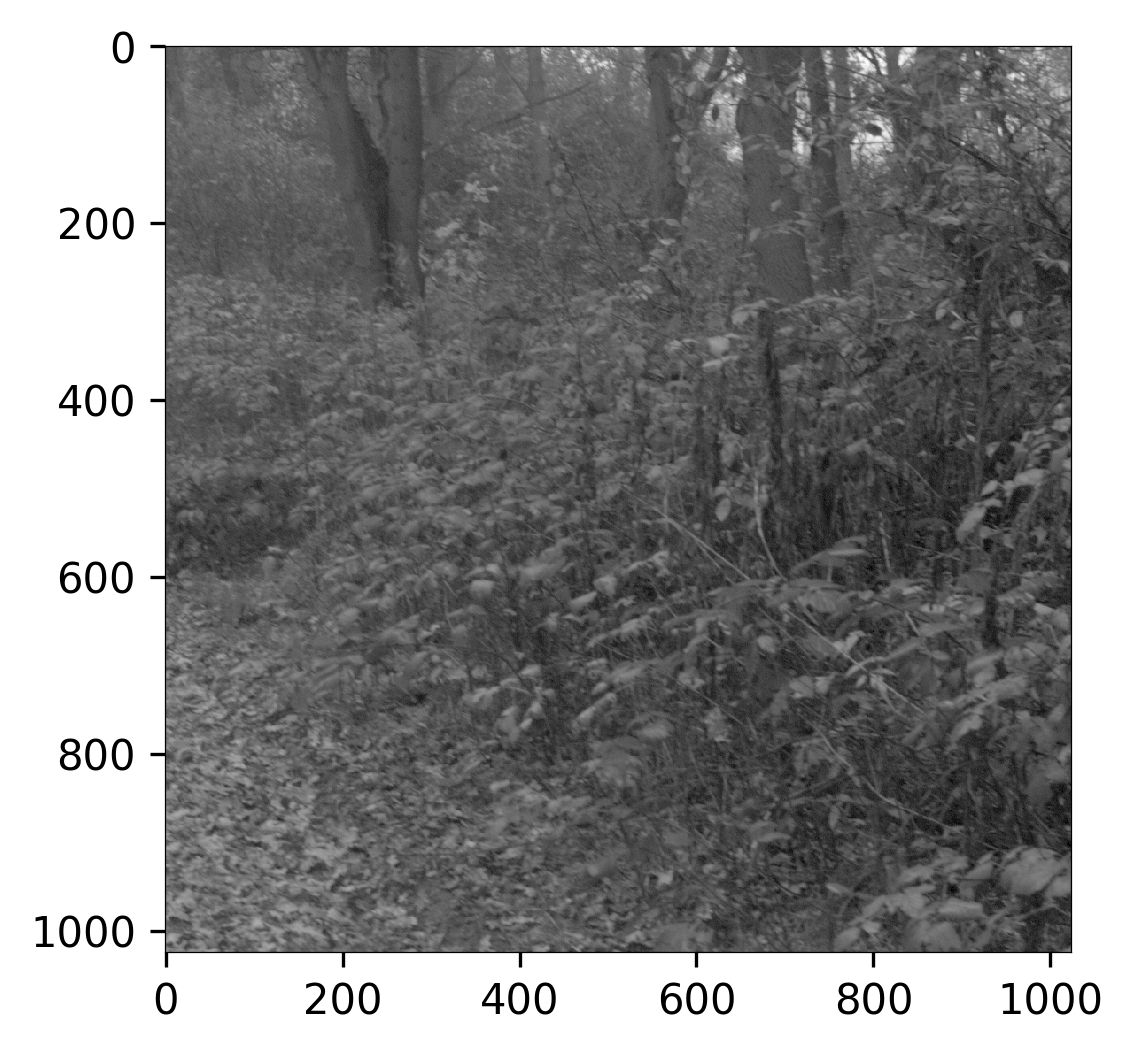

In [12]:
plt.imshow(rawimages[0], cmap='gray')

In [20]:
patches = extract_patches(rawimages, patch_edge_size=32, stride=4, nstim=300000)

image  0
262
image  1
524
image  2
786
image  3
1048
image  4
1310
image  5
1572
image  6
1834
image  7
2096
image  8
2358
image  9
2620
image  10
2882
image  11
3144
image  12
3406
image  13
3668
image  14
3930
image  15
4192
image  16
4454
image  17
4716
image  18
4978
image  19
5240
image  20
5502
image  21
5764
image  22
6026
image  23
6288
image  24
6550
image  25
6812
image  26
7074
image  27
7336
image  28
7598
image  29
7860
image  30
8122
image  31
8384
image  32
8646
image  33
8908
image  34
9170
image  35
9432
image  36
9694
image  37
9956
image  38
10218
image  39
10480
image  40
10742
image  41
11004
image  42
11266
image  43
11528
image  44
11790
image  45
12052
image  46
12314
image  47
12576
image  48
12838
image  49
13100
image  50
13362
image  51
13624
image  52
13886
image  53
14148
image  54
14410
image  55
14672
image  56
14934
image  57
15196
image  58
15458
image  59
15720
image  60
15982
image  61
16244
image  62
16506
image  63
16768
image  64
17030
image  65
1

In [21]:
patches.shape

(296322, 1024)

In [34]:
patches -= patches.mean(1, keepdims=True)
patches /= patches.std(1, keepdims=True)

In [35]:
impca = pca.PCA(dim=256, whiten=True)
reduced = impca.fit_transform(patches, blocks=20000)
origshape = (32, 32)
with open('vh32_256PCA.pickle', 'wb') as f:
    pickle.dump([impca, origshape], f)
reduced /= reduced.std()
np.save('vh32_256.npy', reduced)

In [36]:
np.save('vh32_256covmat.npy', impca.eVectors)
np.save('vh32_256svals.npy', impca.sValues)

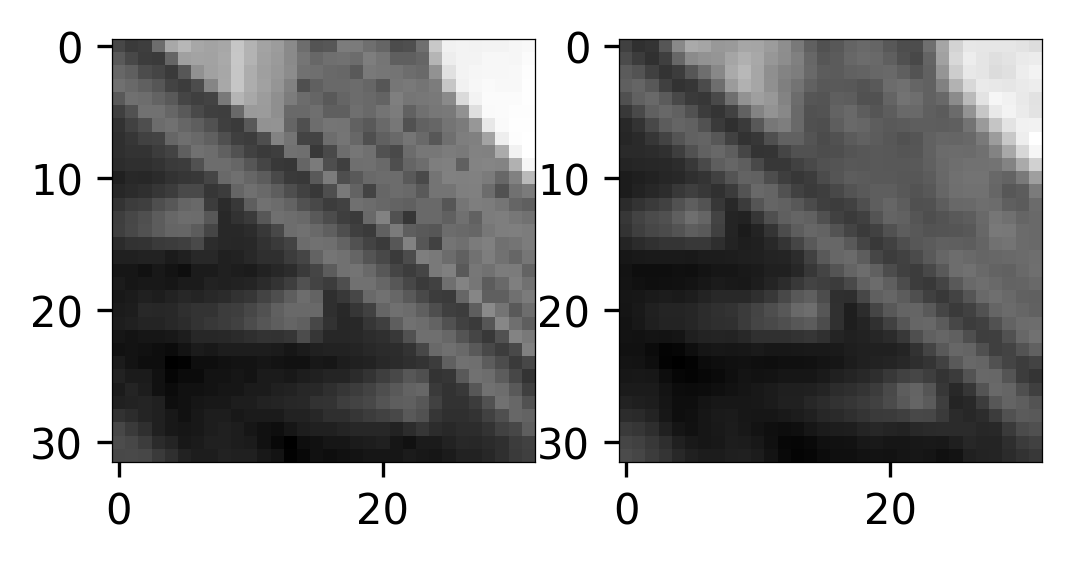

In [37]:
fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(121)
ax.imshow(patches[12345].reshape((32,32)), cmap='gray')
ax = fig.add_subplot(122)
ax.imshow(impca.inverse_transform(reduced[12345]).reshape(origshape), cmap='gray')

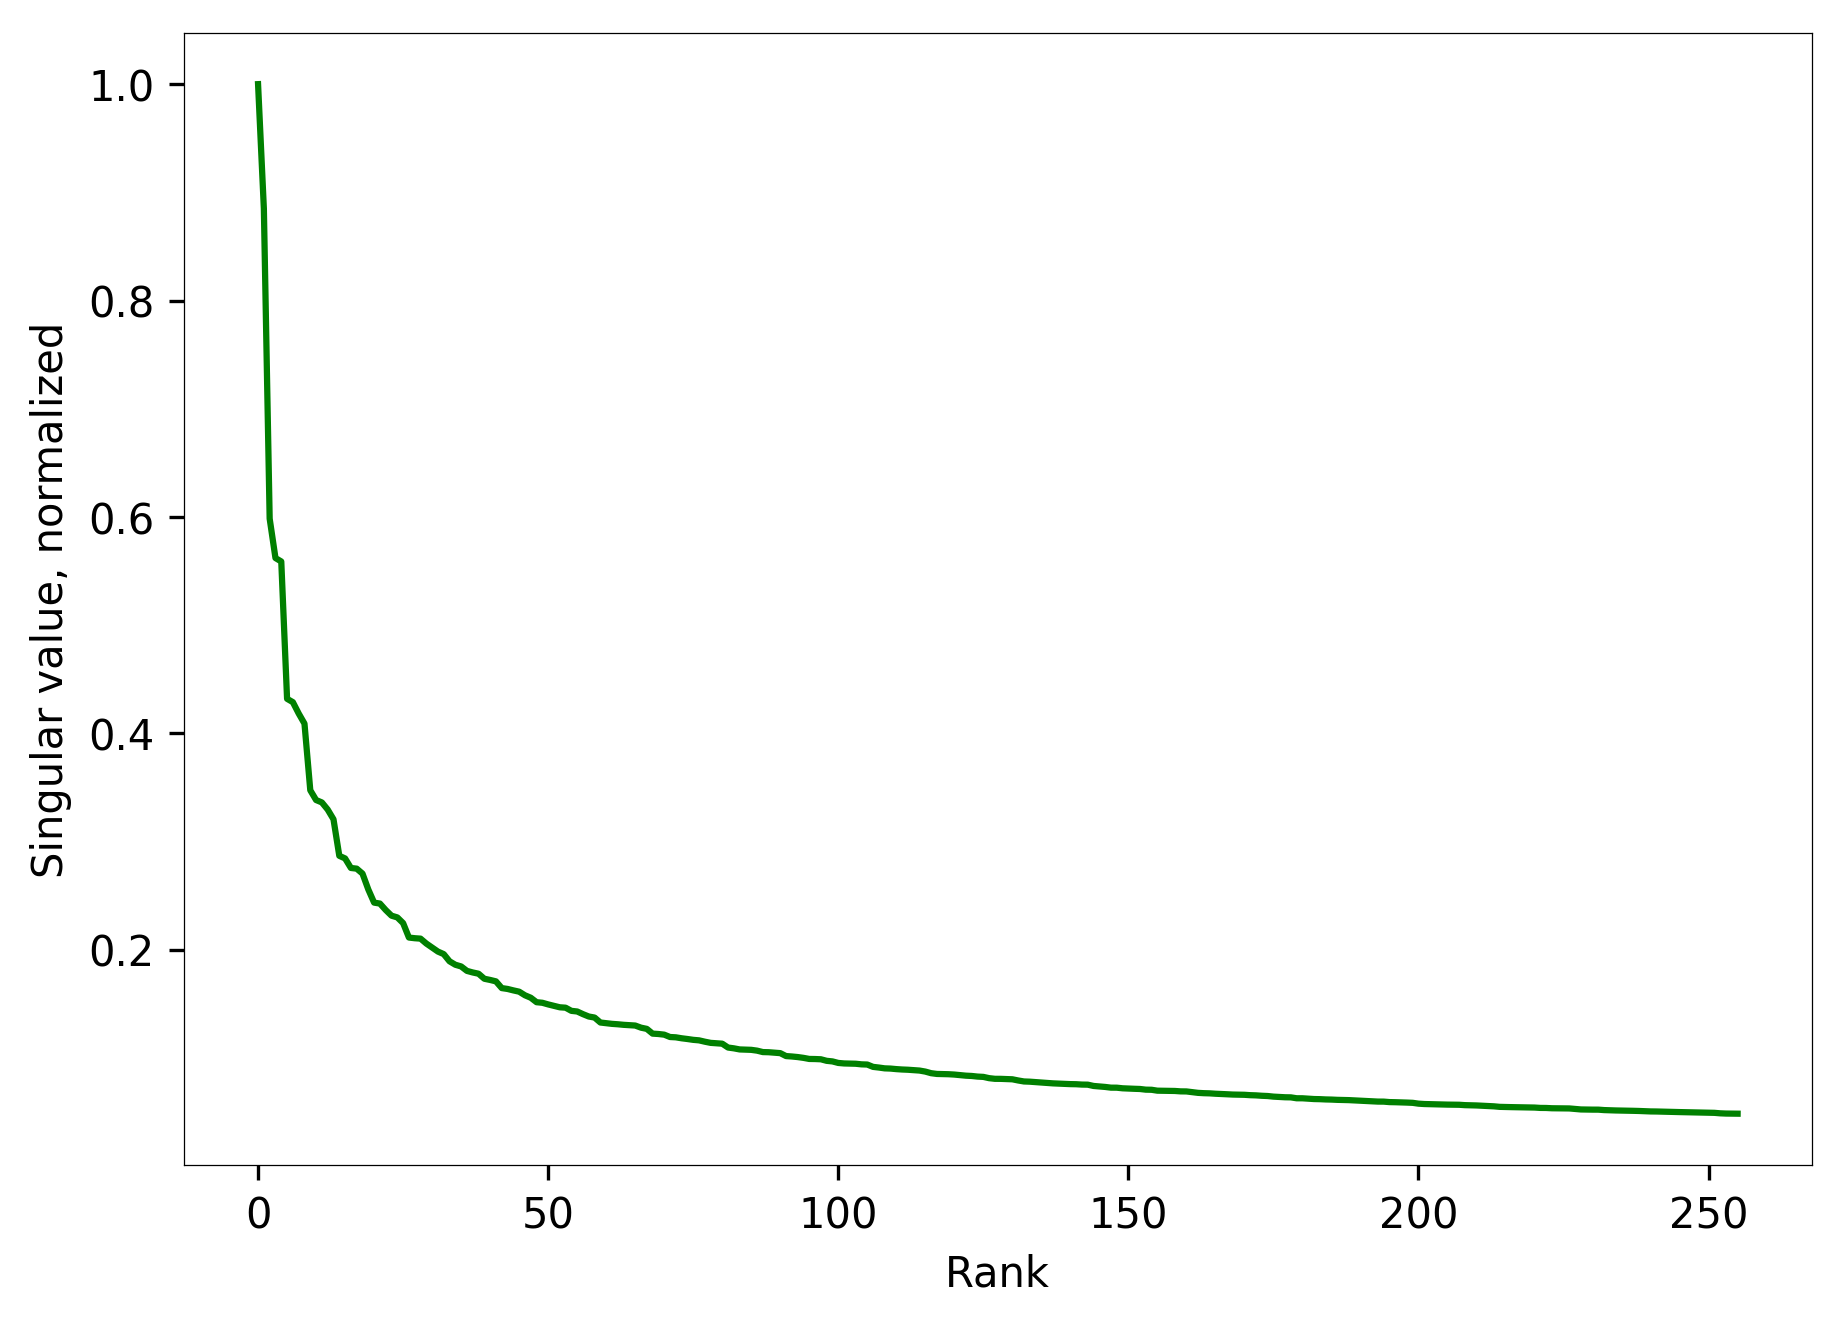

In [3]:
svals = np.load('vh32_256svals.npy')
svals /= np.max(svals)
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(svals[:256], 'g')
ax.set_xlabel('Rank')
ax.set_ylabel('Singular value, normalized')